In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder,  FunctionTransformer
# Metrics
from sklearn.model_selection import GridSearchCV, KFold
import category_encoders as ce
# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error 


# tunning hyperparamters model
import optuna

In [258]:
path = "train.csv"
df = pd.read_csv(path)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


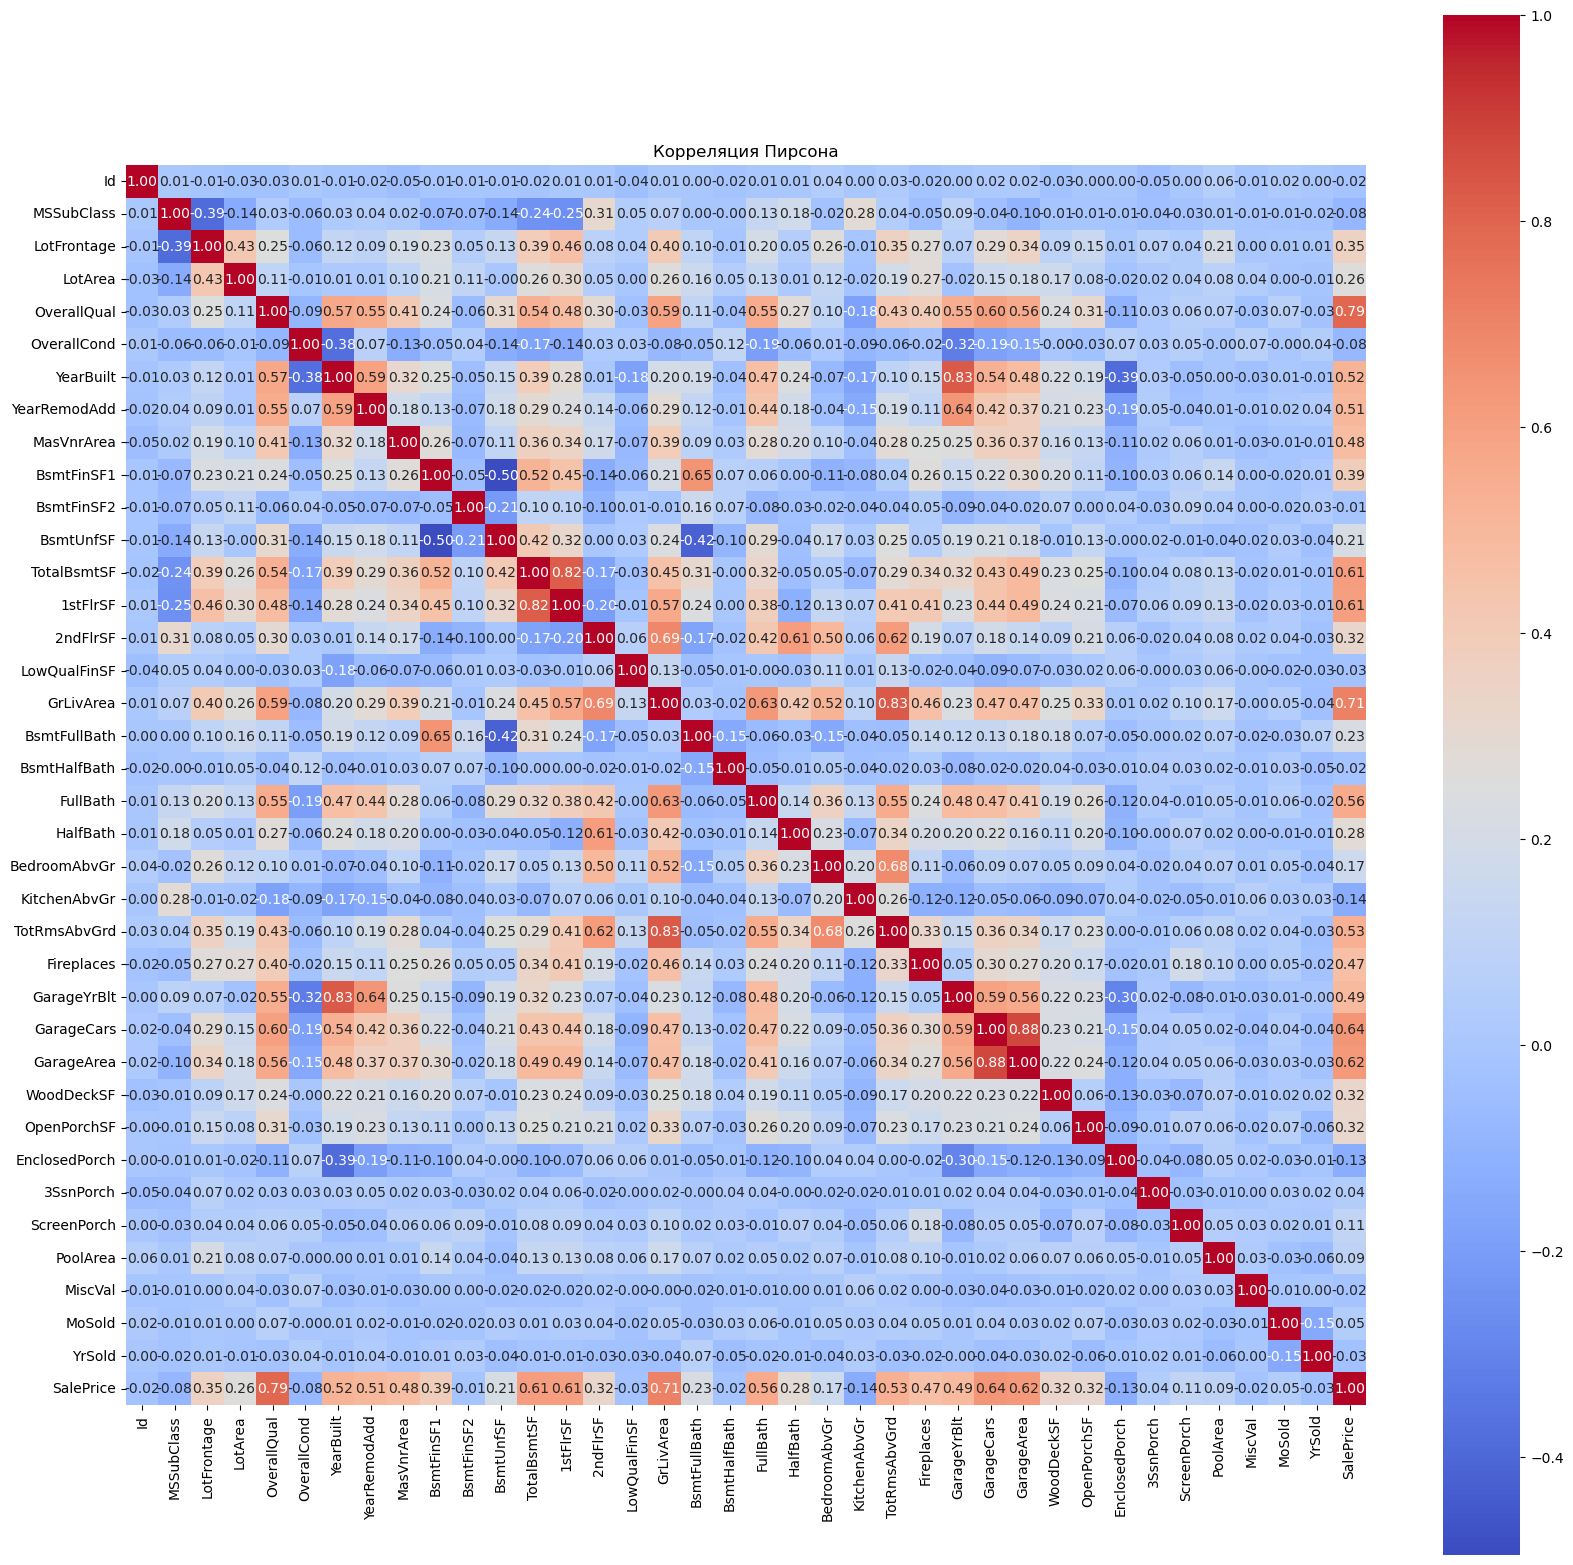

In [259]:


corr_matrix = df.select_dtypes(include="number").corr(method="pearson")
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_matrix,
    annot=True,      # показывать значения
    fmt=".2f",       # 2 знака после запятой
    cmap="coolwarm", # цветовая схема
    square=True
)
plt.title("Корреляция Пирсона")
plt.show()

In [260]:
X,y = df.drop("SalePrice", axis=1), df["SalePrice"]

In [261]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2, random_state = 42)


In [262]:
def feature_engineering_and_drop(X):
    X = X.copy()

    # Общая площадь
    X["TotalSF"] = X['GrLivArea'] + X['TotalBsmtSF']
    X = X.drop(['GrLivArea', 'TotalBsmtSF'], axis=1)

    # Ванные
    X['TotalBath'] = (
        X['FullBath'] + 0.5*X['HalfBath'] +
        X['BsmtFullBath'] + 0.5*X['BsmtHalfBath']
    )
    X = X.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'], axis=1)

    # Террасы
    X['PorchDeckSF'] = (
        X['OpenPorchSF'] + X['EnclosedPorch'] +
        X['3SsnPorch'] + X['ScreenPorch'] + X['WoodDeckSF']
    )
    X = X.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], axis=1)

    # Возраст дома
    X['HouseAge'] = X['YrSold'] - X['YearBuilt']
    X['RemodAge'] = X['YrSold'] - X['YearRemodAdd']
    X = X.drop(['YrSold','YearBuilt','YearRemodAdd'], axis=1)

    # Плотность застройки
    X['SF_per_Lot'] = X['TotalSF'] / X['LotArea']
    X = X.drop(['TotalSF','LotArea'], axis=1)

    # Удаление лишних колонок
    drop_columns = ["Id","PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType",
                    "FireplaceQu", "LotFrontage", 'TotRmsAbvGrd', "GarageYrBlt",
                    "1stFlrSF", '2ndFlrSF', 'GarageArea', "RemodAge"]
    for col in drop_columns:
        if col in X.columns:
            X = X.drop(col, axis=1)

    return X

feature_transformer = FunctionTransformer(feature_engineering_and_drop, validate=False)


In [263]:
X_train_fe = feature_engineering_and_drop(X_train)

# Потом создаём списки колонок
numeric_features = X_train_fe.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train_fe.select_dtypes(include=["object", "category"]).columns.tolist()


In [264]:
imputer = ColumnTransformer(
    transformers=[
        ("numeric_features", SimpleImputer(strategy="median"), numeric_features),
        ("categorical_features", SimpleImputer(strategy="most_frequent"), categorical_features),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough"
)


In [265]:
encoder_and_scaler = ColumnTransformer(
    transformers=[
        ("encoder", ce.CatBoostEncoder(), categorical_features),
        ("scaler", StandardScaler(), numeric_features)
    ],
    verbose_feature_names_out=False,
    remainder="passthrough"
)


In [266]:
preprocessor = Pipeline([
    ("imputer", imputer),
    ("encoder_and_scaler", encoder_and_scaler)
])


In [267]:
model_gbr = GradientBoostingRegressor(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.024850394952947306,
    subsample=0.8433434535775448,
    random_state=42
)

In [268]:
full_pipeline = Pipeline([
    ("features", feature_transformer),  # feature engineering + drop columns
    ("preprocessor", preprocessor),     # imputer + encoder + scaler
    ("model", model_gbr)                # GradientBoostingRegressor
])

In [269]:
full_pipeline.fit(X_train, y_train)


,steps,"[('features', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function fea...x74a23f113380>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [270]:
# Предсказания
y_pred = full_pipeline.predict(X_valid)

# RMSE (корень из MSE)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

# MAE (средняя абсолютная ошибка)
mae = mean_absolute_error(y_valid, y_pred)

# R² (коэффициент детерминации)
r2 = r2_score(y_valid, y_pred)

# RMSLE (корень из среднего квадрата логарифмов ошибок)
# добавляем +1, чтобы избежать log(0)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_valid), np.log1p(y_pred)))

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"RMSLE: {rmsle:.4f}")


RMSE: 27697.02
MAE: 17435.68
R²: 0.900
RMSLE: 0.1451


In [271]:
import joblib

joblib.dump(full_pipeline, "house_price_pipeline.pkl")


['house_price_pipeline.pkl']

In [272]:
import pandas as pd

# X_train, X_valid, y_train, y_valid уже есть

# Объединяем признаки и таргет для сохранения
train_data = X_train.copy()
train_data["SalePrice"] = y_train

valid_data = X_valid.copy()
valid_data["SalePrice"] = y_valid

# Сохраняем в CSV
train_data.to_csv("train_data.csv", index=False)
valid_data.to_csv("valid_data.csv", index=False)


In [273]:
# Проверка в Jupyter или в Streamlit
train_check = pd.read_csv("train_data.csv")
valid_check = pd.read_csv("valid_data.csv")

print(train_check.head())
print(valid_check.head())


     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   255          20       RL         70.0     8400   Pave   NaN      Reg   
1  1067          60       RL         59.0     7837   Pave   NaN      IR1   
2   639          30       RL         67.0     8777   Pave   NaN      Reg   
3   800          50       RL         60.0     7200   Pave   NaN      Reg   
4   381          50       RL         50.0     5000   Pave  Pave      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
3         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      6   2010        WD         Norm

In [274]:
# Загружаем сохранённый pipeline (если он уже обучен и сохранён)
import joblib
full_pipeline = joblib.load("house_price_pipeline.pkl")

# Предсказания на валидационных данных
y_valid_pred = full_pipeline.predict(valid_check.drop("SalePrice", axis=1))

# Сравнение с реальными значениями
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(valid_check["SalePrice"], y_valid_pred))
mae = mean_absolute_error(valid_check["SalePrice"], y_valid_pred)
r2 = r2_score(valid_check["SalePrice"], y_valid_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(valid_check["SalePrice"]), np.log1p(y_valid_pred)))
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}, RMSLE: {rmsle:.4f}")


RMSE: 27697.02, MAE: 17435.68, R²: 0.900, RMSLE: 0.1451


In [279]:
X_train_processed = feature_engineering_and_drop(X_train)
# Берём список колонок после обработки
columns_list = X_train_processed.columns.tolist()
print(columns_list)


['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'TotalBath', 'PorchDeckSF', 'HouseAge', 'SF_per_Lot']
